In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, Activation
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn import metrics as ms
from tensorflow.keras import regularizers

from matplotlib import pyplot
from pickle import load

# X_train = np.load("./saveData/IBM/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/IBM/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/IBM/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/IBM/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/IBM/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/IBM/y_val.npy", allow_pickle=True)

X_train = np.load("./saveData/TSLA/X_train.npy", allow_pickle=True)
y_train = np.load("./saveData/TSLA/y_train.npy", allow_pickle=True)
X_test = np.load("./saveData/TSLA/X_test.npy", allow_pickle=True)
y_test = np.load("./saveData/TSLA/y_test.npy", allow_pickle=True)
X_val = np.load("./saveData/TSLA/X_val.npy", allow_pickle=True)
y_val = np.load("./saveData/TSLA/y_val.npy", allow_pickle=True)

# X_train = np.load("./saveData/S&P500/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/S&P500/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/S&P500/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/S&P500/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/S&P500/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/S&P500/y_val.npy", allow_pickle=True)

# X_train = np.load("./saveData/PAICC/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/PAICC/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/PAICC/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/PAICC/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/PAICC/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/PAICC/y_val.npy", allow_pickle=True)

# X_train = np.load("./saveData/SSE/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/SSE/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/SSE/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/SSE/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/SSE/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/SSE/y_val.npy", allow_pickle=True)

# yc_train = np.load("./saveData/yc_train.npy", allow_pickle=True)
# yc_test = np.load("./saveData/yc_test.npy", allow_pickle=True)

In [169]:
y_train

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [170]:
dict_count = {}
dict_count['跌']=0
dict_count['涨']=0
dict_count['平']=0
for i in range(len(y_train)):
    if(y_train[i][0] ==1):
        dict_count['跌'] += 1
    if(y_train[i][1] == 1):
        dict_count['平'] += 1
    if(y_train[i][2] == 1):
        dict_count['涨'] += 1

In [171]:
dict_count

{'跌': 779, '涨': 857, '平': 444}

In [172]:
y_train.shape[1]

3

In [173]:
# X_train = X_train[0:5001]
# y_train = y_train[0:5001]
# X_test = X_test[0:5001]
# y_test = y_test[0:5001]
# X_val = X_val[0:5001]
# y_val = y_val[0:5001]

In [174]:
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Flatten, RepeatVector ,MaxPooling1D,Bidirectional

In [218]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
min_delta_val = 0.0001
lr_cb = ReduceLROnPlateau(monitor = 'accuracy',  
                          factor = 0.5, min_delta = min_delta_val, patience = 10, verbose = 1)
es_cb = EarlyStopping(monitor = 'accuracy', 
                      min_delta=min_delta_val, patience = 10, verbose = 1, restore_best_weights = True)

callbacks_model = [lr_cb, es_cb]

In [259]:


#Parameters
LR = 0.001
BATCH_SIZE = 60
N_EPOCH = 100
dropout = 0.2
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
#做3分类
output_dim = y_train.shape[1]

#output_dim = 3

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def basic_lstm(input_dim, feature_size):
    
    model = Sequential()
    model.add(GRU(units=64, return_sequences = True, input_shape=(input_dim, feature_size)))
    model.add(Dropout(dropout))
#     model.add(GRU(units=64, return_sequences = True, recurrent_dropout=dropout)) # 256, return_sequences = True
    model.add(GRU(units=32)) #, recurrent_dropout=0.1
    model.add(Dropout(dropout))
    # , recurrent_dropout = 0.2
    model.add(Dense(32))
    model.add(Dropout(dropout))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim,activation='softmax'))

    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = LR),metrics=METRICS)
#     model = Sequential()
#     model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
#     model.add(Dense(64))
#     model.add(Dense(units=output_dim,activation='softmax'))
#     model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_val, y_val),
                        verbose=1, shuffle=False, callbacks=callbacks_model)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return model,history





In [260]:
X_train.shape

(2080, 30, 16)

In [261]:
y_train.shape

(2080, 3)

In [262]:
X_val.shape

(201, 30, 16)

In [263]:
y_val.shape

(201, 3)

In [264]:
y_train

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [265]:
X_train


array([[[-0.99981074, -0.99987062, -0.99979261, ..., -0.05576173,
         -0.9019006 , -0.99477366],
        [-0.99952685, -0.99978585, -0.99987557, ..., -0.02915401,
         -0.94106849, -0.99584901],
        [-1.        , -0.99993754, -1.        , ..., -0.0329735 ,
         -0.96079286, -0.99481336],
        ...,
        [-0.99936463, -0.99951817, -0.99939166, ..., -0.32966625,
         -0.78886345, -0.99896471],
        [-0.99916185, -0.99924156, -0.99920731, ..., -0.11818836,
         -0.81166645, -0.9982161 ],
        [-0.99887346, -0.99893818, -0.9988801 , ...,  0.16512153,
         -0.79154759, -0.99604412]],

       [[-0.99952685, -0.99978585, -0.99987557, ..., -0.02915401,
         -0.94106849, -0.99584901],
        [-1.        , -0.99993754, -1.        , ..., -0.0329735 ,
         -0.96079286, -0.99481336],
        [-0.99995043, -1.        , -0.99991704, ...,  0.05717583,
         -0.97854479, -0.99428401],
        ...,
        [-0.99916185, -0.99924156, -0.99920731, ..., -

Epoch 1/100
35/35 [==============================] - 3s 79ms/step - loss: 1.0321 - tp: 370.0000 - fp: 483.0000 - tn: 3677.0000 - fn: 1710.0000 - accuracy: 0.4202 - precision: 0.4338 - recall: 0.1779 - auc: 0.6455 - prc: 0.4231 - val_loss: 0.8975 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 401.0000 - val_fn: 199.0000 - val_accuracy: 0.4876 - val_precision: 0.6667 - val_recall: 0.0100 - val_auc: 0.7018 - val_prc: 0.4720
Epoch 2/100
35/35 [==============================] - 1s 37ms/step - loss: 1.1894 - tp: 85.0000 - fp: 201.0000 - tn: 3959.0000 - fn: 1995.0000 - accuracy: 0.3861 - precision: 0.2972 - recall: 0.0409 - auc: 0.5229 - prc: 0.3406 - val_loss: 0.9829 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 402.0000 - val_fn: 201.0000 - val_accuracy: 0.4627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7100 - val_prc: 0.4915
Epoch 3/100
35/35 [==============================] - 1s 42ms/step - loss: 1.0778 - tp: 28.0000 - fp: 44.0000 - tn: 4116.0000 - fn: 2052.0000 

Epoch 20/100
35/35 [==============================] - 1s 37ms/step - loss: 0.9809 - tp: 267.0000 - fp: 278.0000 - tn: 3882.0000 - fn: 1813.0000 - accuracy: 0.4812 - precision: 0.4899 - recall: 0.1284 - auc: 0.6890 - prc: 0.4645 - val_loss: 0.9732 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 402.0000 - val_fn: 201.0000 - val_accuracy: 0.4826 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7011 - val_prc: 0.4594
Epoch 21/100
35/35 [==============================] - 1s 30ms/step - loss: 0.9829 - tp: 233.0000 - fp: 255.0000 - tn: 3905.0000 - fn: 1847.0000 - accuracy: 0.4678 - precision: 0.4775 - recall: 0.1120 - auc: 0.6835 - prc: 0.4606 - val_loss: 0.9679 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 400.0000 - val_fn: 200.0000 - val_accuracy: 0.4826 - val_precision: 0.3333 - val_recall: 0.0050 - val_auc: 0.7012 - val_prc: 0.4573
Epoch 22/100
35/35 [==============================] - 1s 30ms/step - loss: 0.9811 - tp: 250.0000 - fp: 292.0000 - tn: 3868.0000 - fn: 1830

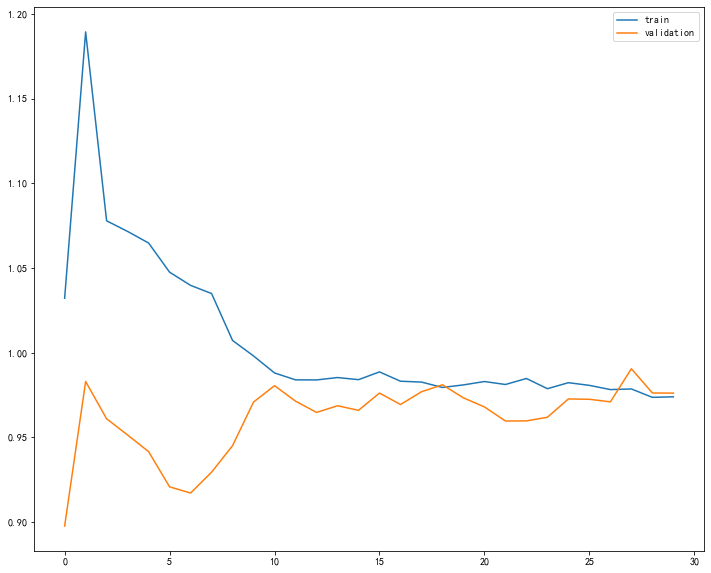

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 (None, 30, 64)            15744     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
gru_18 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                

In [266]:
model,history= basic_lstm(input_dim, feature_size)
model.save('./saveModel/GRU_3to1.h5')
print(model.summary())


In [267]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc', 'lr'])

In [268]:
acc = history_dict['accuracy']

In [269]:
acc

[0.42019230127334595,
 0.38605770468711853,
 0.4014423191547394,
 0.4057692289352417,
 0.40625,
 0.4028846025466919,
 0.42115384340286255,
 0.4091346263885498,
 0.4413461685180664,
 0.45913460850715637,
 0.4615384638309479,
 0.4706730842590332,
 0.4759615361690521,
 0.4644230902194977,
 0.4673076868057251,
 0.4634615480899811,
 0.4711538553237915,
 0.4639423191547394,
 0.4769230782985687,
 0.48124998807907104,
 0.4677884578704834,
 0.4706730842590332,
 0.4644230902194977,
 0.4721153974533081,
 0.4692307710647583,
 0.4634615480899811,
 0.4596153795719147,
 0.4697115421295166,
 0.4754807651042938,
 0.47884616255760193]

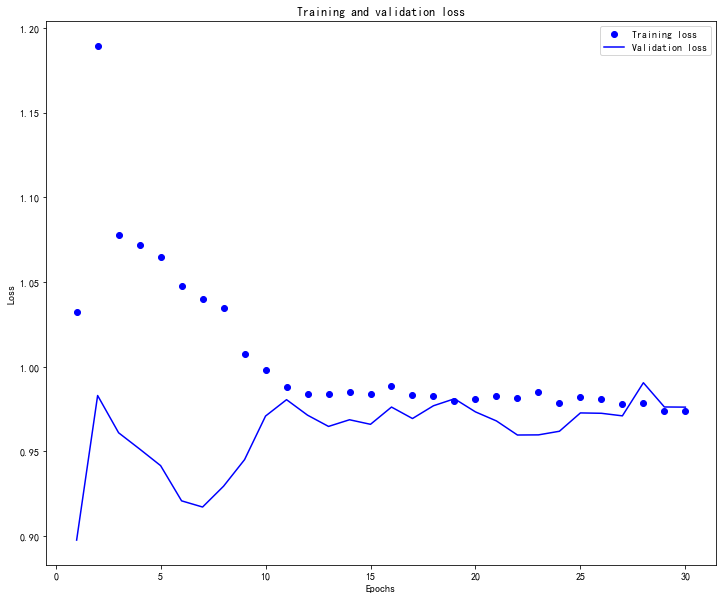

In [270]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

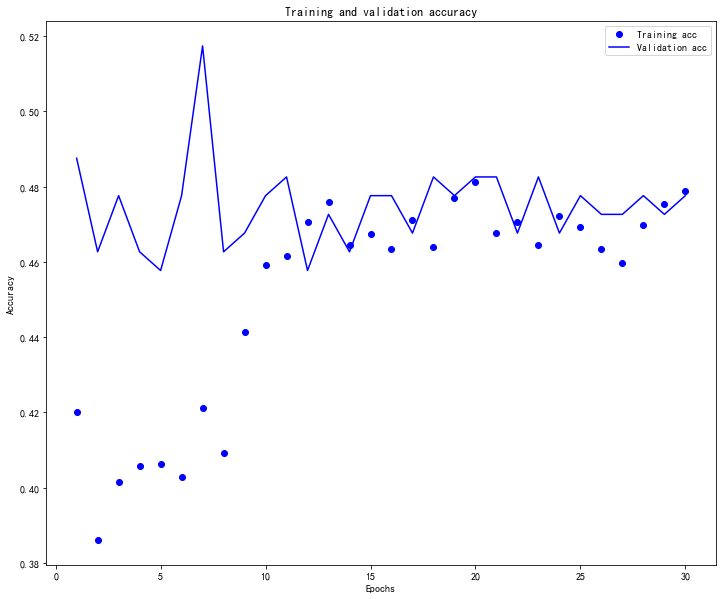

In [271]:
plt.clf()   # 清除数字
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [272]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [273]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

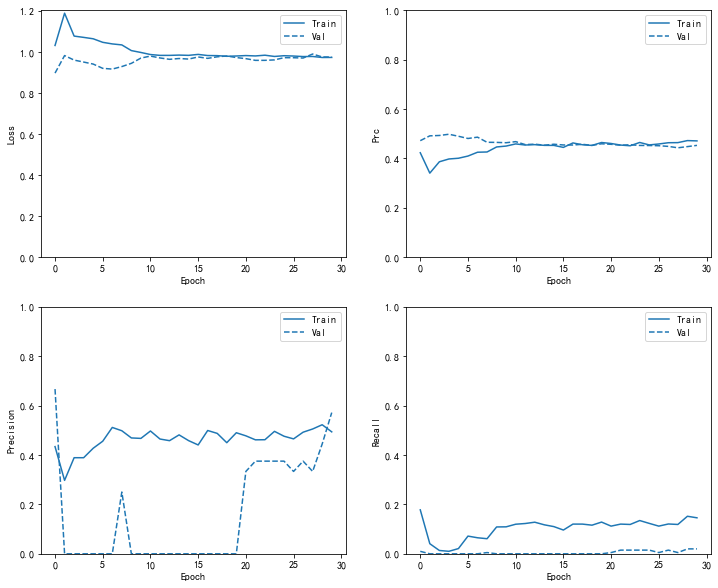

In [274]:
plot_metrics(history)

### Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics 
### You can use a confusion matrix to summarize the actual vs. predicted labels where the X axis is the predicted label  and the Y axis is the actual label.

In [275]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

In [276]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

#plot_cm(y_test, test_predictions_baseline)

loss :  0.8085535168647766
tp :  138.0
fp :  166.0
tn :  640.0
fn :  265.0
accuracy :  0.4838709533214569
precision :  0.45394736528396606
recall :  0.3424317538738251
auc :  0.7328720092773438
prc :  0.47943681478500366



# 绘制ROC曲线

In [277]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.preprocessing import label_binarize


In [278]:
#同时也是分类得分y_score
#概率矩阵P和标签矩阵L分别对应代码中的y_score和y_one_hot：
yhat = model.predict(X_test, verbose=0)


In [279]:
from sklearn.preprocessing import label_binarize


In [280]:
y_test

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [281]:
yhat

array([[0.34816712, 0.24515508, 0.40667784],
       [0.3460559 , 0.24234092, 0.41160318],
       [0.3441578 , 0.2458104 , 0.41003177],
       ...,
       [0.5626528 , 0.02880505, 0.40854213],
       [0.5589068 , 0.02968514, 0.41140807],
       [0.5548416 , 0.03128716, 0.4138713 ]], dtype=float32)

调用函数auc： 0.7325717786575868
手动计算auc： 0.7325717786575868


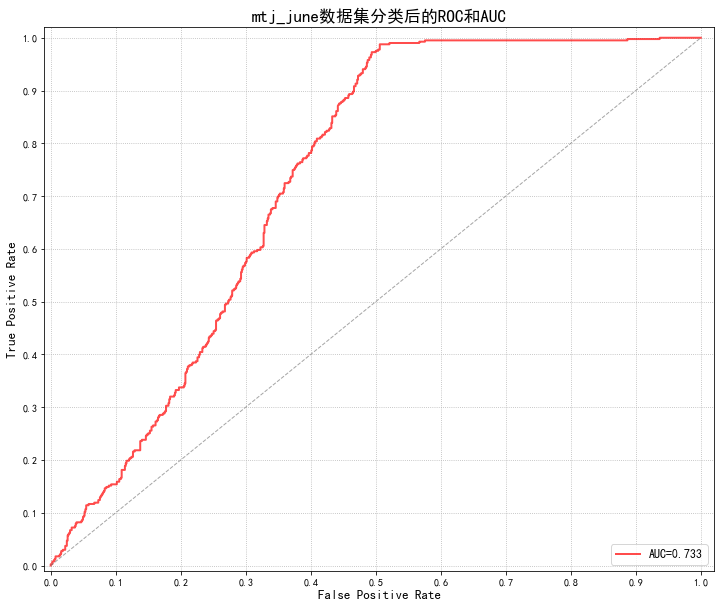

In [282]:
# 计算属于各个类别的概率，返回值的shape = [n_samples, n_classes]
y_score = model.predict(X_test)
# 1、调用函数计算micro类型的AUC
print('调用函数auc：', metrics.roc_auc_score(y_test, y_score, average='micro'))
# 2、手动计算micro类型的AUC
#首先将矩阵y_one_hot和y_score展开，然后计算假正例率FPR和真正例率TPR
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(),y_score.ravel())
auc = metrics.auc(fpr, tpr)
print('手动计算auc：', auc)
#绘图
mpl.rcParams['font.sans-serif'] = u'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
#FPR就是横坐标,TPR就是纵坐标
plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'mtj_june数据集分类后的ROC和AUC', fontsize=17)
plt.show()

<ipython-input-283-72ed8574a92e>:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


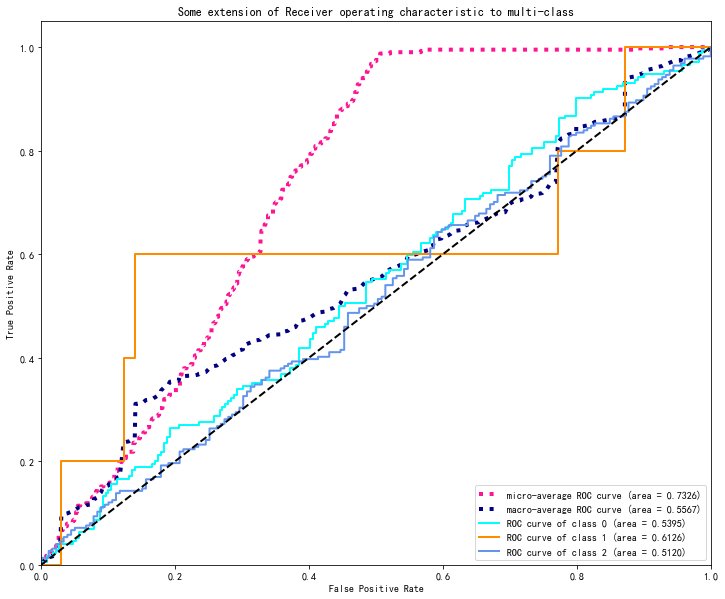

In [283]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
# 计算每一类的ROC

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]) )

plt.plot([0, 1], [0, 1], 'k--', lw=lw )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [284]:
dict_count = {}
dict_count['跌']=0
dict_count['涨']=0
dict_count['平']=0
for i in range(len(y_train)):
    if(y_train[i][0] ==1):
        dict_count['跌'] += 1
    if(y_train[i][1] == 1):
        dict_count['平'] += 1
    if(y_train[i][2] == 1):
        dict_count['涨'] += 1

In [285]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
def to_0_1(y):
    res = []
    for i in range(y.shape[0]):
        if(y[i][0] > y[i][1] and y[i][0] > y[i][2]):
            res.append(-1) #跌
        if(y[i][1] > y[i][0] and y[i][1] > y[i][2]):
            res.append(0) #平
        if(y[i][2] > y[i][0] and y[i][2] > y[i][1]):
            res.append(1) #涨
    return np.array(res)

def result_to_0_1(y):
        if(tf.is_tensor(y)):
            y = y.numpy()
            for i in range(y.shape[0]):
                max_index = 0
                if(y[i][max_index] < y[i][1]):
                    max_index = 1
                if(y[i][max_index] < y[i][2]):
                    max_index = 2
                list_temp = [0,1,2]
                list_temp.pop(max_index)
                y[i][max_index] = 1
                y[i][list_temp[0]] = 0
                y[i][list_temp[1]] = 0
        else:
            for i in range(y.shape[0]):
                max_index = 0
                if(y[i][max_index] < y[i][1]):
                    max_index = 1
                if(y[i][max_index] < y[i][2]):
                    max_index = 2
                list_temp = [0,1,2]
                list_temp.pop(max_index)
                y[i][max_index] = 1
                y[i][list_temp[0]] = 0
                y[i][list_temp[1]] = 0
        return y

In [286]:
y = result_to_0_1(yhat)

In [287]:
y_pre = to_0_1(yhat)
y_true = to_0_1(y_test)

In [288]:
y_pre

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [289]:
y_true

array([ 1, -1,  1,  1,  0, -1, -1,  0, -1,  1,  0,  1,  1,  1,  1,  1, -1,
        1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1, -1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1,
       -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
        1,  0,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,
       -1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1, -1,
        1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  0,  1,
       -1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1, -1, -1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,
       -1,  1,  1,  1,  1

In [290]:
cm = confusion_matrix(y_true, y_pre)
conf_matrix = pd.DataFrame(cm, index=['涨','平','跌'], columns=['涨','平','跌'])

In [291]:
cm

array([[144,   0,  30],
       [  2,   0,   3],
       [173,   0,  51]], dtype=int64)

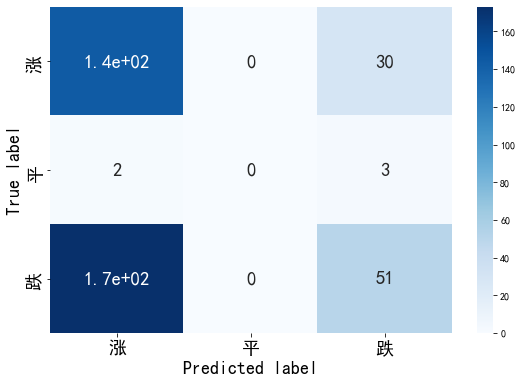

In [292]:
# plot size setting
fig, ax = plt.subplots(figsize = (9,6))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 19}, cmap="Blues")
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('confusion.pdf', bbox_inches='tight')
plt.show()

In [293]:
dict_count = {}
dict_count['跌']=0
dict_count['涨']=0
dict_count['平']=0
for i in range(len(y_test)):
    if(y_train[i][0] ==1):
        dict_count['跌'] += 1
    if(y_train[i][1] == 1):
        dict_count['平'] += 1
    if(y_train[i][2] == 1):
        dict_count['涨'] += 1
        


In [294]:
dict_count

{'跌': 91, '涨': 109, '平': 203}

In [295]:
print('------Weighted------')
print('Weighted precision', precision_score(y_true, y_pre, average='weighted'))
print('Weighted recall', recall_score(y_true, y_pre, average='weighted'))
print('Weighted f1-score', f1_score(y_true, y_pre, average='weighted'))
print('------Macro------')
print('Macro precision', precision_score(y_true, y_pre, average='macro'))
print('Macro recall', recall_score(y_true, y_pre, average='macro'))
print('Macro f1-score', f1_score(y_true, y_pre, average='macro'))
print('------Micro------')
print('Micro precision', precision_score(y_true, y_pre, average='micro'))
print('Micro recall', recall_score(y_true, y_pre, average='micro'))
print('Micro f1-score', f1_score(y_true, y_pre, average='micro'))

------Weighted------
Weighted precision 0.5323708549515002
Weighted recall 0.4838709677419355
Weighted f1-score 0.43629994294130914
------Macro------
Macro precision 0.35285117181668907
Macro recall 0.3517549261083744
Macro f1-score 0.30511577671821083
------Micro------
Micro precision 0.4838709677419355
Micro recall 0.4838709677419355
Micro f1-score 0.4838709677419355


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [256]:
tp = pd.DataFrame()
tp['CS'] = yhat.tolist()

In [257]:
tp.describe()

,CS
count,403
unique,2
top,"[1.0, 0.0, 0.0]"
freq,310


In [258]:
yhat.shape

(403, 3)

In [216]:
yhat = model.predict(X_test, verbose=0)
#print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

# %% --------------------------------------- Plot the TRAIN result  -----------------------------------------------------------------
## TRAIN DATA
def plot_traindataset_result(X_train, y_train):


    train_yhat = model.predict(X_train, verbose=0)

    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
    #
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Train RMSE -- ', RMSE)

    return RMSE






# %% --------------------------------------- Plot the TEST result  -----------------------------------------------------------------
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2020-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE -- ', RMSE)

    return RMSE

def plot_testdataset_with2020_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2020", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE with 2020 -- ', RMSE)

    return RMSE

train_RMSE = plot_traindataset_result(X_train, y_train)
print("----- Train_RMSE_LSTM -----", train_RMSE)

test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_LSTM -----", test_RMSE)

test_with2020_RMSE = plot_testdataset_with2020_result(X_test, y_test)
print("----- Test_RMSE_LSTM_with2020 -----", test_with2020_RMSE)


0.5106925914227056


FileNotFoundError: [Errno 2] No such file or directory: 'train_predict_index.npy'